In [2]:
import numpy as np
import scipy.linalg as sla
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import time
import shelve
%matplotlib notebook
%load_ext line_profiler
%load_ext memory_profiler
%load_ext cython

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [168]:
I = J = 8192
BW = 2**np.arange(2, 8)
for bw in BW:
    print('Bandwidth:', bw)
    L = U = bw//2
    Ab = random_banded_complex(I, J, L, U)
    A_csc = Ab.todia().tocsc()
    # Time factorization
    print('Factorization:')
    %timeit qr_banded(Ab)
    %timeit spla.splu(A_csc, permc_spec="NATURAL")
    # Time solve
    Q, R = qr_banded(Ab)
    LU = spla.splu(A_csc, permc_spec="NATURAL")
    b = np.random.rand(J) + 1j*np.random.rand(J)
    print('Solve:')
    %timeit solve_qr(Q, R, b)
    %timeit LU.solve(b)
    print()

Bandwidth: 4
Factorization:
1.68 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
10.8 ms ± 665 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Solve:
993 µs ± 129 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
404 µs ± 42.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Bandwidth: 8
Factorization:
2.48 ms ± 229 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.63 ms ± 281 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Solve:
1.37 ms ± 14 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
454 µs ± 6.65 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Bandwidth: 16
Factorization:
5.58 ms ± 91.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
17.2 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Solve:
2.24 ms ± 44.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
636 µs ± 14.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Bandwidth: 32
Factorization:
18 m

In [9]:
tqr = [1.58, 2.65, 6.76, 19.1, 67.8, 222]
tlu = [10.2, 10.8, 23.1, 52.6, 131, 408]

<IPython.core.display.Javascript object>


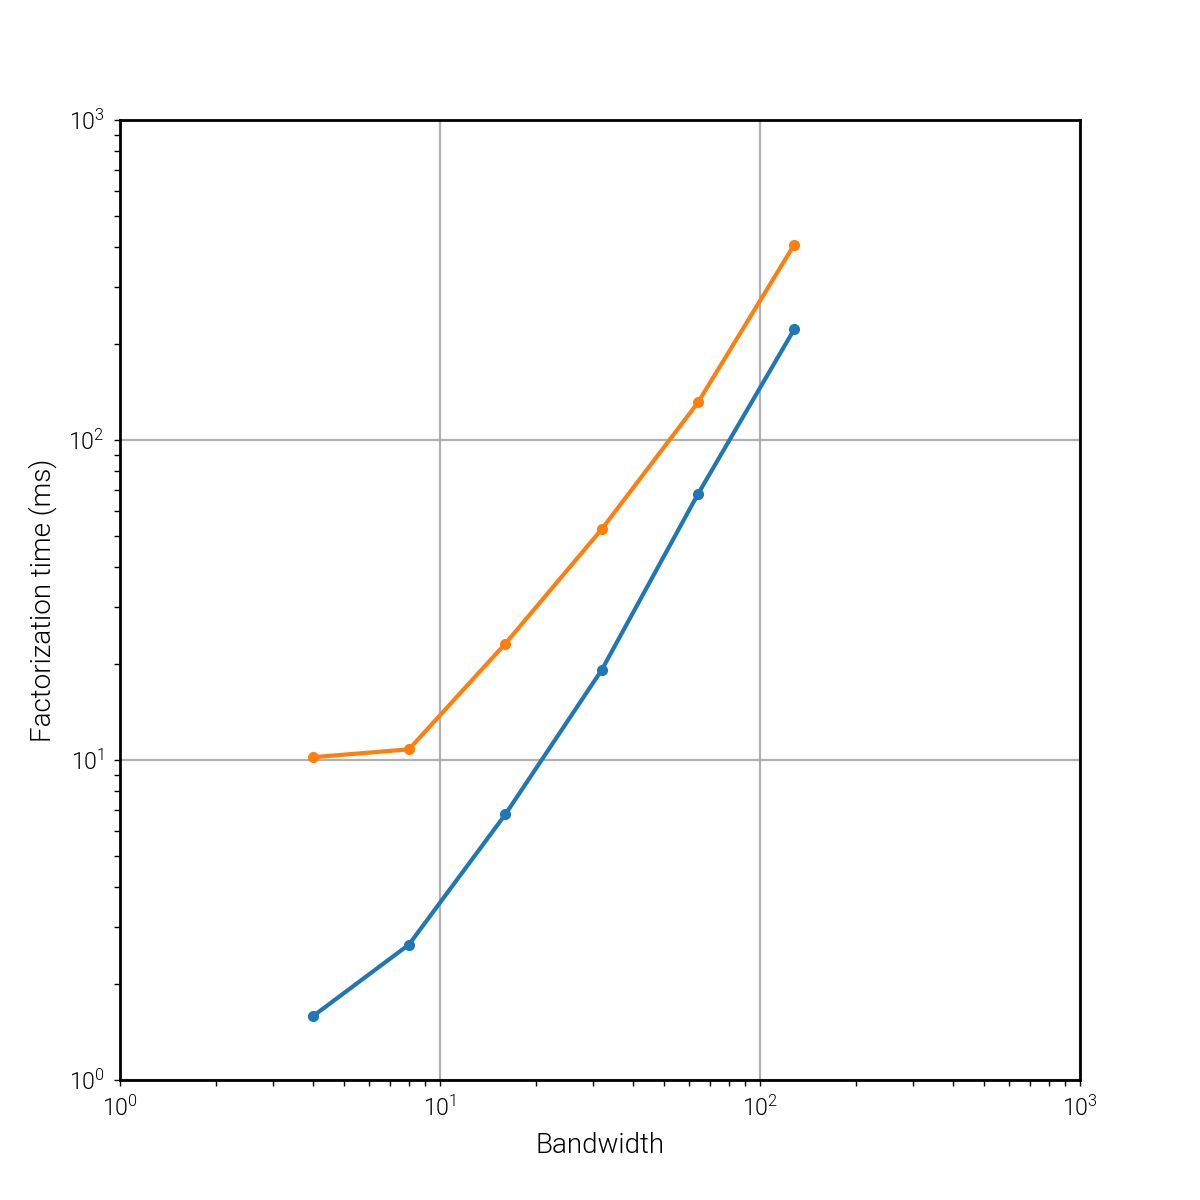

In [20]:
plt.figure(figsize=(6,6))
plt.loglog(BW, tqr, '.-')
plt.loglog(BW, tlu, '.-')
plt.xlim([1,10**3])
plt.ylim([1,10**3])
plt.xlabel('Bandwidth')
plt.ylabel('Factorization time (ms)')
plt.grid()

In [24]:
matrices = shelve.open("matrices.dat", "r")
matrices['LHS']

[<112x112 sparse matrix of type '<class 'numpy.complex128'>'
 	with 716 stored elements in Compressed Sparse Row format>,
 <224x224 sparse matrix of type '<class 'numpy.complex128'>'
 	with 1658 stored elements in Compressed Sparse Row format>,
 <448x448 sparse matrix of type '<class 'numpy.complex128'>'
 	with 3546 stored elements in Compressed Sparse Row format>,
 <896x896 sparse matrix of type '<class 'numpy.complex128'>'
 	with 7322 stored elements in Compressed Sparse Row format>,
 <1792x1792 sparse matrix of type '<class 'numpy.complex128'>'
 	with 14874 stored elements in Compressed Sparse Row format>,
 <3584x3584 sparse matrix of type '<class 'numpy.complex128'>'
 	with 29978 stored elements in Compressed Sparse Row format>,
 <7168x7168 sparse matrix of type '<class 'numpy.complex128'>'
 	with 60186 stored elements in Compressed Sparse Row format>,
 <14336x14336 sparse matrix of type '<class 'numpy.complex128'>'
 	with 120602 stored elements in Compressed Sparse Row format>]

In [169]:
index = -2
A_csr = matrices['LHS'][index]
b = matrices['RHS'][index]
A_csc = A_csr.tocsc()
A_ban = BandedMatrix.from_sparse(A_csr)

In [170]:
%timeit qr_banded(A_ban)
%timeit spla.splu(A_csc, permc_spec="NATURAL")

508 ms ± 6.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
32.9 ms ± 800 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [171]:
Q, R = qr_banded(A_ban)
LU = spla.splu(A_csc, permc_spec="NATURAL")

%timeit solve_qr(Q, R, b)
%timeit LU.solve(b)

40.7 ms ± 725 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.21 ms ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
%prun solve_qr(Q, R, b)

In [ ]:
%memit qr_banded(A_ban)

In [ ]:
%memit LU = spla.splu(A_csc, permc_spec="NATURAL")
%memit LU.solve(b)

## Plot timing / scaling

In [ ]:
def time_solve(N, U, L, fact_loops=1, solve_loops=10):
    # Build square matrix
    M = N
    data = np.random.rand(L+U+1, N) + 1j*np.random.rand(L+U+1, N)
    offsets = np.arange(-L, U+1)
    Ad = sp.dia_matrix((data, offsets), shape=(M, N))
    Ab = BandedMatrix.from_sparse(Ad)
    # Factorize
    time_fact_start = time.time()
    for i in range(fact_loops):
        Q, R = qr_banded(Ab)
    time_fact_end = time.time()
    time_fact = (time_fact_end - time_fact_start) / fact_loops
    # Solve
    b = np.random.rand(N) + 1j*np.random.rand(N)
    time_solve_start = time.time()
    for i in range(solve_loops):
        x = solve_qr(Q, R, b)
    time_solve_end = time.time()
    time_solve = (time_solve_end - time_solve_start) / solve_loops
    return time_fact, time_solve

In [ ]:
time_solve(100, 5, 5)

In [ ]:
U, L = 5, 10
N = 2**np.arange(4, 13)
times = np.array([time_solve(n, U, L) for n in N])

In [ ]:
plt.figure()
plt.loglog(N, times[:,0], '.-', label='fact')
plt.loglog(N, times[:,1], '.-', label='solve')
plt.legend()
plt.grid()
plt.xlabel('N')
plt.ylabel('Time (s)')

In [142]:
I = 32
J = 32
L = 0
U = 4

A_ban = random_banded_complex(I, J, L, U)
b = np.random.rand(J)+1j

In [172]:
index = -2
A_csr = matrices['LHS'][index]
b = matrices['RHS'][index]
A_csc = A_csr.tocsc()
A_ban = BandedMatrix.from_sparse(A_csr)

Q, R = qr_banded(A_ban)
I, J = A_ban.shape
L, U = R.L, R.U

A_ban = R
b = Q.H@b

In [173]:
x = sla.solve_banded((L, U), A_ban.data, b)
print(np.allclose(A_ban@x,b))
x

True


array([-2.66320751e+01-4.30156927j,  7.50170869e-01+0.09688376j,
        1.42245912e-01-1.2356768j , ..., -2.06329639e-01-0.17795711j,
       -6.54717947e-04+0.11180641j,  7.95936177e-01-0.38764047j])

In [174]:
xL = b.copy()
info = solve_banded_upper_triangular(A_ban.data, xL, I, J, U)
print(info)
print(np.allclose(A_ban@xL,b))
xL

0
True


array([-2.66320751e+01-4.30156927j,  7.50170869e-01+0.09688376j,
        1.42245912e-01-1.2356768j , ..., -2.06329639e-01-0.17795711j,
       -6.54717947e-04+0.11180641j,  7.95936177e-01-0.38764047j])

In [177]:
%timeit solve_banded_upper_triangular(A_ban.data, b.copy(), I, J, U)
%timeit sla.solve_banded((L, U), A_ban.data, b)

2.87 ms ± 444 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
36.6 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>


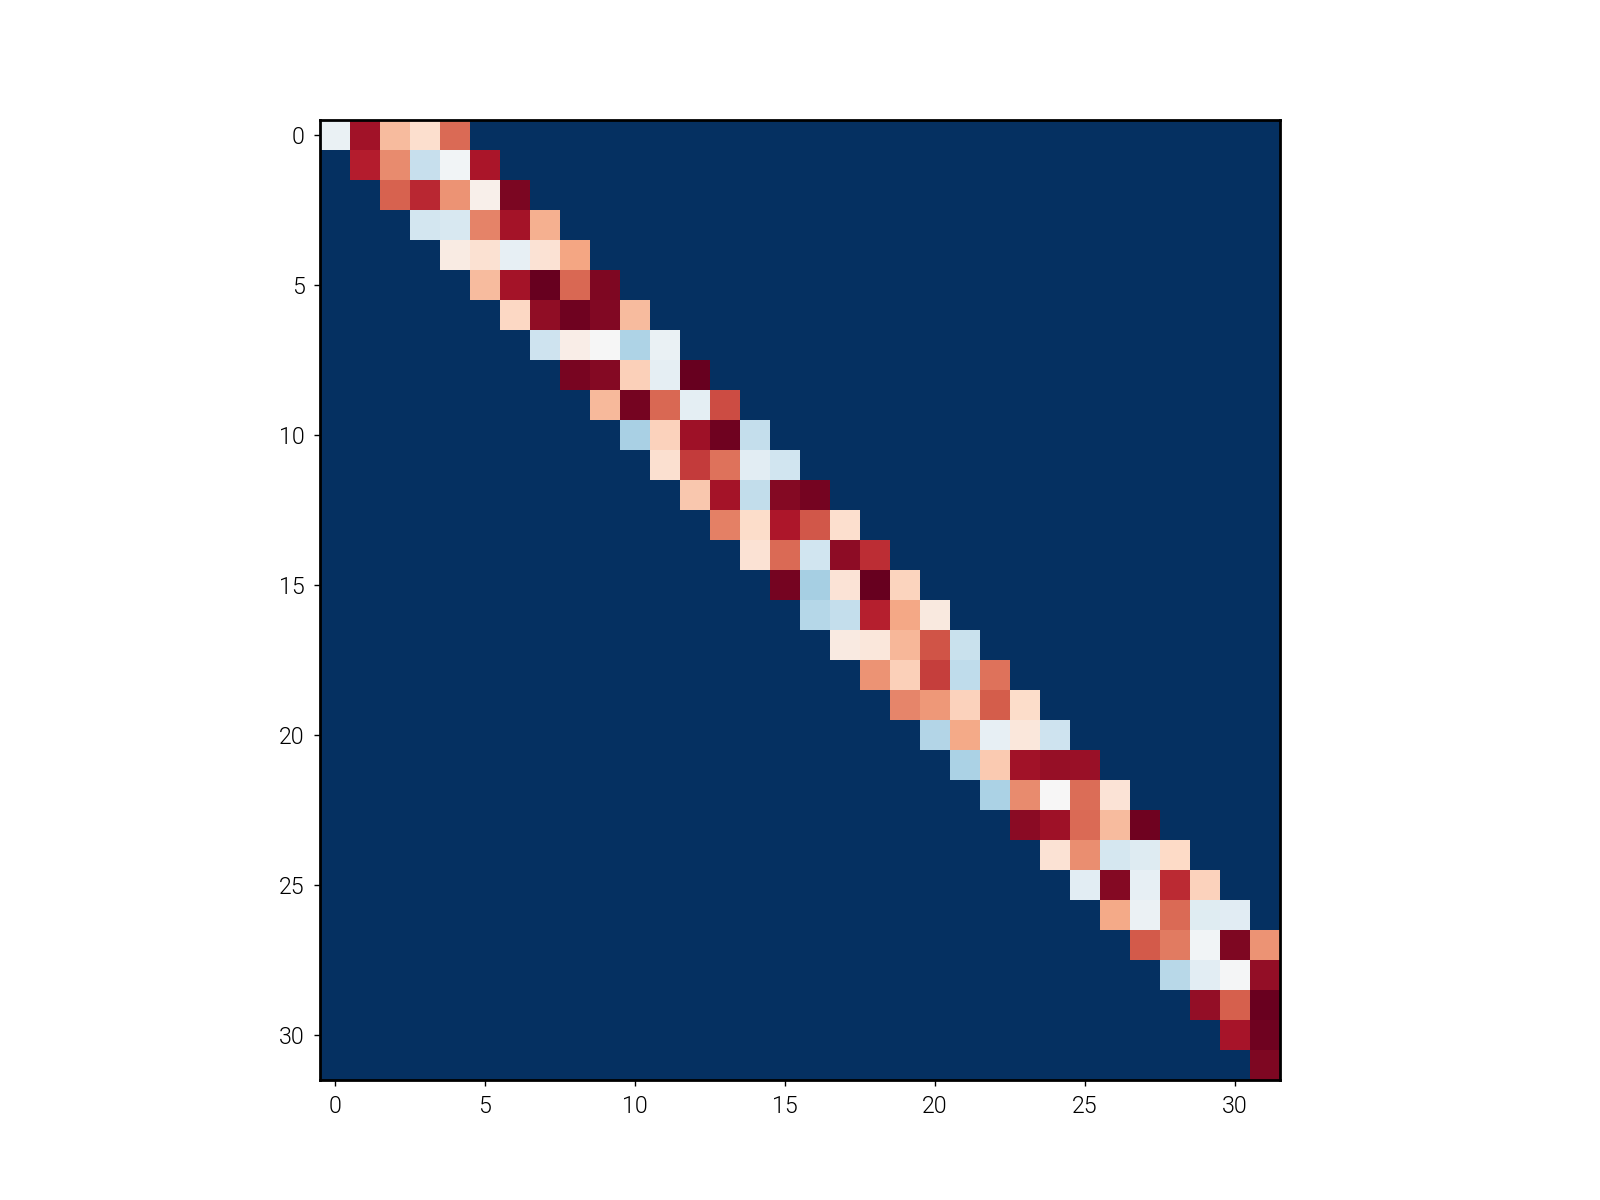

In [104]:
plt.figure()
plt.imshow(A_ban.todia().A)

In [178]:
LU.shape

(7168, 7168)